# In this notebook, I am going to implement a deep network from numpy



In [1]:
# Python Standard Library struct and array
# for dealing with reading dataset from file
import struct
from array import array

# Numpy for calculating
import numpy as np

# To draw the training and dev cost value curve
import matplotlib.pyplot as plt
%matplotlib inline

# Test Cases
import test

# Some Useful Helper Functions
import helper

## Load MNIST Dataset

In [2]:
def load_mnist():
    """ 
    load MNIST dataset into numpy array 
    MNIST dataset can be downloaded manually.
    url: http://yann.lecun.com/exdb/mnist/
    """
    ret = {}
    with open('MNIST/train-images.idx3-ubyte', 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        assert(magic==2051)
        ret['X_train'] = np.array(array("B", f.read())).reshape(size,rows,cols)

    with open('MNIST/t10k-images.idx3-ubyte', 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        assert(magic==2051)
        ret['X_test'] = np.array(array("B", f.read())).reshape(size,rows,cols)

    with open('MNIST/train-labels.idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        assert(magic==2049)
        ret['Y_train'] = np.array(array("B", f.read())).reshape(size,1)

    with open('MNIST/t10k-labels.idx1-ubyte', 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        assert(magic==2049)
        ret['Y_test'] = np.array(array("B", f.read())).reshape(size,1)

    return ret

## Shuffle and divide the dataset

In [3]:
def shuffle_divide_dataset( dataset, len_of_dev=10000 ):
    """
    Shuffle and divide the dataset
    
    len_of_dev: 10,000 is a reasonable number for dev set.
                Dev dataset with this size is big enough to measure variance problem.
    """       
    assert('X_train' in dataset)
    assert(len(dataset)==4)
    
    """ random shuffle the training set """
    np.random.seed(1)
    permutation = np.random.permutation(dataset['X_train'].shape[0])
    dataset['X_train'] = dataset['X_train'][permutation]
    dataset['Y_train'] = dataset['Y_train'][permutation]

    """ divide trainset into trainset and devset """
    dataset['X_dev'] = dataset['X_train'][:len_of_dev]
    dataset['Y_dev'] = dataset['Y_train'][:len_of_dev]
    dataset['X_train'] = dataset['X_train'][len_of_dev:]
    dataset['Y_train'] = dataset['Y_train'][len_of_dev:]

    print('X_train:', dataset['X_train'].shape,
          'X_dev:', dataset['X_dev'].shape,
          'X_test:', dataset['X_test'].shape)
    print('Y_train:', dataset['Y_train'].shape,
          'Y_dev:', dataset['Y_dev'].shape,
          'Y_test:', dataset['Y_test'].shape)
    return dataset

## Manually check the dataset by random visualize some of them

In [4]:
def manually_validate_mnist_dataset(dataset):
    """Manually check the dataset by random visualize some of them"""
    random_train = np.random.randint(1, len(dataset['X_train']))-1
    random_dev = np.random.randint(1, len(dataset['X_dev']))-1
    random_test = np.random.randint(1, len(dataset['X_test']))-1
    print(dataset['Y_train'][random_train], dataset['Y_dev'][random_dev], dataset['Y_test'][random_test])
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=[10,3])
    ax1.imshow(dataset['X_train'][random_train], cmap='gray')
    ax2.imshow(dataset['X_dev'][random_dev], cmap='gray')
    mappable = ax3.imshow(dataset['X_test'][random_test], cmap='gray')
    fig.colorbar(mappable)
    plt.show()

## Standardize the dataset

$$
z = \frac{x - \mu}{\sigma}
$$

#### Notice: the MNIST gray images have a lot of areas of black (0), relatively few areas of white(255), so the standardization has a result of roughly (-0.4, 2.8).
#### Maybe we can also use divide 256 to scale the dataset.

In [5]:
def standardize( dataset ):
    """use standard sccore to normalize input dataset"""
    assert('X_train' in dataset)
    mu = np.mean(dataset['X_train'], keepdims=False)
    sigma = np.std(dataset['X_train'], keepdims=False)
    for key, val in dataset.items():
        if key[:2]=='X_':
            dataset[key] = ( dataset[key] - mu ) / sigma
    return dataset

## Preprocess dataset into vectors
#### Notice: Andrew's course use the format of vector above, but tensorflow does it in it's transpose way.
## Flat Images(X) into vectors, and stack them into matrix

#### Input Format: X (m, width, height); Output Format:
$$ X = 
\begin{bmatrix}
\vert & & \vert & & \vert \\
x^{(1)} & ... & x^{(i)} & ... & x^{(m)} \\
\vert & & \vert & & \vert
\end{bmatrix} 
$$

In [6]:
def flat_stack( dataset ):
    """input dataset format: (m, width, height)"""
    for key, val in dataset.items():
        if key[:2]=='X_':
            width = dataset[key].shape[1]
            height = dataset[key].shape[2]
            dataset[key] = dataset[key].reshape(-1, width*height).T
    return dataset

## One hot encode Labels(Y)
#### Input Format: Y (m, label_number); output Format:
$$
Y = 
\begin{bmatrix}
\vert & & \vert & & \vert \\
y_{one\_hot}^{(1)} & ... & y_{one\_hot}^{(i)} & ... & y_{one\_hot}^{(m)} \\
\vert & & \vert & & \vert \\
\end{bmatrix}
$$


In [7]:
def one_hot( dataset ):
    min_label_number = np.min(dataset['Y_train'], keepdims=False)
    max_label_number = np.max(dataset['Y_train'], keepdims=False)
    C = max_label_number - min_label_number + 1
    for key, val in dataset.items():
        if key[:2]=='Y_':
            # all label number should be trained in Y_train
            assert(min_label_number <= np.min(dataset[key], keepdims=False))
            assert(max_label_number >= np.max(dataset[key], keepdims=False))
            Y = dataset[key]
            Y_onehot = np.zeros((C, Y.shape[0]))
            Y_onehot[Y.reshape(-1).astype(int), np.arange(Y.shape[0])] = 1
            dataset[key] = Y_onehot
    return dataset

def back_one_hot(Y_onehot):
    """ This is an inverse function of one hot, in case we need to interpret the result. """
    Y = np.repeat( [np.arange(Y_onehot.shape[0])], repeats=Y_onehot.shape[1], axis=0 )
    assert(Y.shape == Y_onehot.T.shape)
    Y = Y[Y_onehot.T.astype(bool)]
    return Y.reshape(-1,1)

## Init cache, parameters, hyper_parameters

**cache** is used for store results in steps, such as Z1, A1, Z2, A2 and so on.

**parameters** are the model itself, consist of W and b, which can be adjusted during training.

**hyper_parameters** are the settings for training.

_(I am still thinking should the structure of the network be a parameter? Or should there be structure, parameters, training conditions?)_

In [8]:
def init(X_size, hidden_layers=[10,10,5], C=10, learning_rate=0.01, regularization=0.1):
    """ init cache, parameters and hyper_parameters """
    global cache, parameters, hyper_parameters
    cache = {}
    parameters = {}
    hyper_parameters = {}

    """ init hyper_parameters """
    hyper_parameters['X_size'] = X_size
    # layers of network, include the last softmax layer
    # hidden layers use ReLU activation function, and the last layer use Softmax function
    hyper_parameters['layers'] = hidden_layers + [C]
    # L layers in total
    hyper_parameters['L'] = len(hyper_parameters['layers'])
    # Class numbers 0-9 is 10
    hyper_parameters['C'] = C
    hyper_parameters['learning_rate'] = learning_rate
    hyper_parameters['regularization'] = regularization
    # tiny_float to avoid divide by zero
    hyper_parameters['tiny_float'] = 1e-7
    
    """ init W b or any other parameters in every layer """
    layers = hyper_parameters['layers']
    x_size = hyper_parameters['X_size']
    cells_prev = x_size
    for layer_idx, cells in enumerate(layers):
        parameters['W'+str(layer_idx+1)] = np.random.randn(cells, cells_prev) * 0.01
        parameters['b'+str(layer_idx+1)] = np.zeros((cells, 1))
        cells_prev = layers[layer_idx]


# ------------------------------------------------------------------------------------------------
# after this line, the code is still waiting for refactory
# I paste those code just for testing, make sure I don't have any 
# mistake above.

In [9]:
def ReLU(X):
    return X * (X > 0)

In [10]:
def softmax(X):
    s = np.sum(np.exp(X), axis=0)
    return np.exp(X) / s

In [11]:
def forward_propagation_each_layer(W, A_prev, b, activation_function=ReLU):
    Z = np.dot(W, A_prev) + b
    A = activation_function(Z)
    return Z,A

In [12]:
def loss(Y_hat, Y):
    A = np.multiply(Y, np.log(Y_hat+hyper_parameters['tiny_float']))
    B = np.multiply(1-Y, np.log(1-Y_hat+hyper_parameters['tiny_float']))
    Loss = -A-B
    #why not use Loss = -np.sum(A+B) / m?
    return Loss

def cost(loss):
    return np.mean(loss)

def cost_with_regularization(cost):
    global parameters, hyper_parameters
    if hyper_parameters['regularization']==0:
        return cost
    s = 0
    for i in range(hyper_parameters['L']):
        L = str(i+1)
        s += np.sum(np.mean(np.dot(parameters['W'+L].T, parameters['W'+L]), axis=1), keepdims=False)
    
    cost += hyper_parameters['regularization'] / 2 * s
    return cost

In [13]:
def predict(Y_hat):
    return np.argmax(Y_hat,axis=0).reshape(-1,1)

def accuracy(Y_predict, Y):
    return np.sum(np.equal(Y_predict, back_one_hot(Y))) / Y_predict.shape[0]

In [14]:
def backpropagate_cost(Y, AL):
    #m = Y.shape[1] #why not 1/m?
    #dAL = -np.divide(Y, AL) #why not use this formula?
    dAL = - (np.divide(Y, AL+hyper_parameters['tiny_float']) - np.divide(1 - Y, 1 - AL+hyper_parameters['tiny_float']))
    return dAL

def backpropagate_softmax(AL, dAL, Y=None, ZL=None):
    dZ = np.multiply(dAL, (AL-np.power(AL,2)))
    return dZ

def backpropagate_linear(dZ, W, A_prev):
    m = dZ.shape[1] # I still don't know why move 1/m here from backpropagate_cost.
    dA_prev = np.dot(W.T, dZ)
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1).reshape(-1,1)
    return dA_prev, dW, db

def backpropagate_ReLU(dA, Z):
    return np.multiply(dA, (Z>=0).astype(np.float32))

In [15]:
""" neural network logic level """

def forwardpropagation_all(X):
    global cache, parameters, hyper_parameters
    layers = hyper_parameters['layers']
    A_prev = X
    for layer_idx, cells in enumerate(layers):
        W = parameters['W'+str(layer_idx+1)]
        b = parameters['b'+str(layer_idx+1)]
        if layer_idx==len(layers)-1:
            # Last layer's activation function should be softmax
            Z, A = forward_propagation_each_layer(W, A_prev, b, softmax)
        else:
            Z, A = forward_propagation_each_layer(W, A_prev, b)
        cache['Z'+str(layer_idx+1)] = Z
        cache['A'+str(layer_idx+1)] = A
        A_prev = A

def backpropagate_all(X, Y):
    global cache, parameters, hyper_parameters
    # 1. Last layer has coss function and softmax function
    L = str(hyper_parameters['L'])
    cache['dA'+L] = backpropagate_cost(Y,cache['A'+L])
    AL = cache['A'+L]
    dAL = cache['dA'+L]
    cache['dZ'+L] = backpropagate_softmax(AL, dAL)

    # 2. Layers in between are similar: linear and ReLU
    for i in np.arange(start=hyper_parameters['L']-1, stop=0, step=-1):
        L = str(i)
        cache['dA'+L], cache['dW'+str(i+1)], cache['db'+str(i+1)] = backpropagate_linear(cache['dZ'+str(i+1)], 
                                                                           parameters['W'+str(i+1)], 
                                                                           cache['A'+L])
        cache['dZ'+L] = backpropagate_ReLU(cache['dA'+L], cache['Z'+L])

    # 3. First layer has different parameter.
    _, cache['dW1'], cache['db1'] = backpropagate_linear(cache['dZ1'], parameters['W1'], X)

def update_parameters():
    global cache, parameters
    m = cache['dZ1'].shape[1]
    for i in range(hyper_parameters['L']):
        L = str(i+1)
        parameters['W'+L] -= cache['dW'+L] * hyper_parameters['learning_rate'] \
        + hyper_parameters['regularization'] * parameters['W'+L] * hyper_parameters['learning_rate'] / m
        parameters['b'+L] -= cache['db'+L] * hyper_parameters['learning_rate']

In [16]:
def model(X_full, Y_full, X_dev, Y_dev, 
          learning_rate=0.01, print_every=100, iteration=500, 
          hidden_layers=[100], batch_size=128, regularization=0):
    init(hidden_layers=hidden_layers, C=Y_full.shape[0], X_size=X_full.shape[0], 
         learning_rate=learning_rate, regularization=regularization)
    # costs will be returned for plotting
    costs = []
    costs_index = []
    costs_dev = []
    costs_dev_index = []
    m = X_full.shape[1]
    step = 0
    np.random.seed(1)
    for i in range(iteration):
        permutation = np.random.permutation(m)
        X_permutated = X_full[:, permutation]
        Y_permutated = Y_full[:, permutation]
        for j in range( m // batch_size ):
            X = X_permutated[:, j*batch_size:(j+1)*batch_size]
            Y = Y_permutated[:, j*batch_size:(j+1)*batch_size]
            if X.shape[1]==batch_size:
                forwardpropagation_all(X)
                Y_hat = cache['A'+str(hyper_parameters['L'])]
                cost_value = cost_with_regularization(cost(loss(Y_hat, Y)))
                costs.append(cost_value)
                costs_index.append(step)
                backpropagate_all(X, Y)
                update_parameters()
                
                step += 1
                if step%print_every==0:
                    Y_predict = predict(Y_hat)
                    accu = accuracy(Y_predict, Y)

                    forwardpropagation_all(X_dev)
                    Y_hat_dev = cache['A'+str(hyper_parameters['L'])]
                    cost_dev_value = cost_with_regularization(cost(loss(Y_hat_dev, Y_dev)))
                    costs_dev.append(cost_dev_value)
                    costs_dev_index.append(step)
                    Y_predict_dev = predict(Y_hat_dev)
                    accu_dev = accuracy(Y_predict_dev, Y_dev)

                    print(step,'>',i,'-th iter, training error = ',cost_value,'; accu_train = ',accu)
                    print(' > dev error = ',cost_dev_value,'; accu_dev = ', accu_dev)
                if np.isnan(cost_value):
                    print("ERROR to nan!!!")
                    break
            else:
                print("Batch_Size ERROR!!!")
    return costs, costs_index, costs_dev, costs_dev_index

X_train: (50000, 28, 28) X_dev: (10000, 28, 28) X_test: (10000, 28, 28)
Y_train: (50000, 1) Y_dev: (10000, 1) Y_test: (10000, 1)
100 > 0 -th iter, training error =  0.0707874748674 ; accu_train =  0.859375
 > dev error =  0.0592800287817 ; accu_dev =  0.8905
200 > 0 -th iter, training error =  0.0397765790065 ; accu_train =  0.9453125
 > dev error =  0.0331147758066 ; accu_dev =  0.9408
300 > 0 -th iter, training error =  0.0281383620182 ; accu_train =  0.9453125
 > dev error =  0.0281435353728 ; accu_dev =  0.9528
400 > 1 -th iter, training error =  0.0207596016396 ; accu_train =  0.9453125
 > dev error =  0.0253027252948 ; accu_dev =  0.9572
500 > 1 -th iter, training error =  0.0168401238311 ; accu_train =  0.9609375
 > dev error =  0.0233806247853 ; accu_dev =  0.9603
600 > 1 -th iter, training error =  0.00579511963313 ; accu_train =  0.9921875
 > dev error =  0.0178080258046 ; accu_dev =  0.9705
700 > 1 -th iter, training error =  0.0183387479383 ; accu_train =  0.9609375
 > dev 

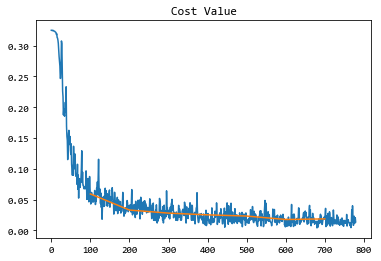

In [17]:
def test_model():
    """test model using random data"""
    m = 10
    X = np.random.randn(784,m)
    Y = one_hot(np.random.randint(low=0, high=10, size=(m,1)), C=10)
    #print(X[:,1])
    #print(Y[:,1])
    costs = model(X,Y,learning_rate=0.1, print_every=10, iteration=100,
                 hidden_layers=[10,10])
    plt.plot(costs)
    plt.show()
    
def test_model_1():
    """test model using real MNIST dataset"""
    mnist = load_mnist()
    mnist = shuffle_divide_dataset(mnist)
    mnist = standardize(mnist)
    mnist = flat_stack(mnist)
    mnist = one_hot(mnist)
    
    costs, costs_index, costs_dev, costs_dev_index = \
    model(mnist['X_train'], mnist['Y_train'], mnist['X_dev'], mnist['Y_dev'],
                  learning_rate=0.3, print_every=100, iteration=2,
                  batch_size=128, regularization=0,
                  hidden_layers=[784,100])
    
    plt.plot(costs_index, costs)
    plt.plot(costs_dev_index, costs_dev)
    plt.title("Cost Value")
    plt.show()
    
test_model_1()